In [1]:
from glob import glob
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Eddy Covariance (Speulderbos)

With glob() we select all files fitting the description ('*' is a wildcard)
As we now know how many files there are, we know the amount of datapoints we will have, and can create arrays of the right size.

In [2]:
#Get the path of all files:
files = glob('ec_data\\*.csv')

#Arrays to put covariances in:
cov_w_Ts  = np.zeros(len(files))
cov_w_H2O = np.zeros(len(files))

#Array to put time in
dtime_array = np.empty(len(files), dtype=object)

Now let's load in all the files using pandas, and then calculate the covariances 

In [3]:
for ii in range(0,len(files)):
    #Read out each csv
    df = pd.read_csv(files[ii], header=0)
    
    #Calculate covariances
    cov_w_Ts[ii]  = np.cov(df.uz,df.Ts)[0,1] #Select element 0,1 from covariance matrix
    cov_w_H2O[ii] = np.cov(df.uz,df.H2O)[0,1]
    
    #Get the time from the filename
    file_time       = files[ii].split('_')[-1]
    dtime_array[ii] = datetime.strptime(file_time, '%Y%m%d%H%M.csv')

We can now use the covariances to calculate the eddy fluxes
First sensible heat:

Text(0,0.5,'H (W/m$^2$)')

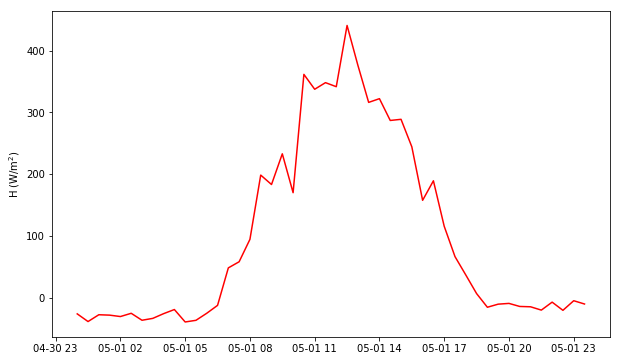

In [4]:
c_p   = 1003 #J/kg/K
rho_a = 1.25 #kg/m3
H = c_p * rho_a * cov_w_Ts

plt.figure(figsize=(10,6))
plt.plot(dtime_array, H, 'r')
plt.ylabel('H (W/m$^2$)')

And then the latent heat:

Text(0,0.5,'$\\rho \\lambda E$ (W/m$^2$)')

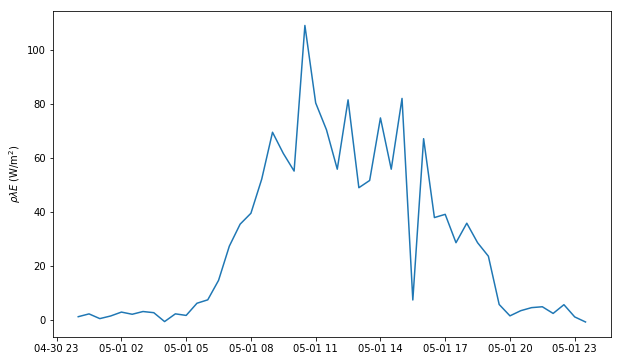

In [5]:
Lambda = 2.45e6 #
rho_w  = 1000   #kg/m3

#Molar mass water
M_water = 18.015 #g/mol

#convert H20 concentration from mmol m^-3 --> kg/m3
cov_w_q = cov_w_H2O/1e6 * M_water

#Calculate latent heat flux:
LE = cov_w_q * Lambda

plt.figure(figsize=(10,6))
plt.plot(dtime_array, LE)
plt.ylabel(r'$\rho \lambda E$ (W/m$^2$)')

In [6]:
seconds_per_day = 3600*24

#Total energy for evaporation:
evap_energy     = LE.mean() * 3600*24 #-> J/m2/d

#Conversion to mm/d:
E               = evap_energy/Lambda/rho_w #m3/m2/d = m/d
E               = E*1000 #mm/d

print('Total daily evaporation: %.2f mm' % E)

Total daily evaporation: 1.03 mm


# EddyPro comparison

In [7]:
df_eddypro = pd.read_excel('eddypro_data\\eddypro_output.xls', header=[0], skiprows=[1])

NameError: name 'H_FV' is not defined

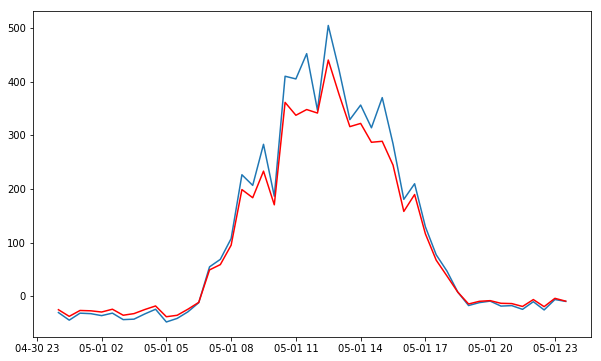

In [8]:
plt.figure(figsize=(10,6))
plt.plot(dtime_array, df_eddypro.H, label='H, EddyPro')
plt.plot(dtime_array, H, 'r', label='H, EC')
plt.plot(dtime_array, H_FV, 'g', label='H, FV')
plt.legend(loc='best')
plt.ylabel('H (W/m$^2$)')

Text(0,0.5,'$\\rho \\lambda E$ (W/m$^2$)')

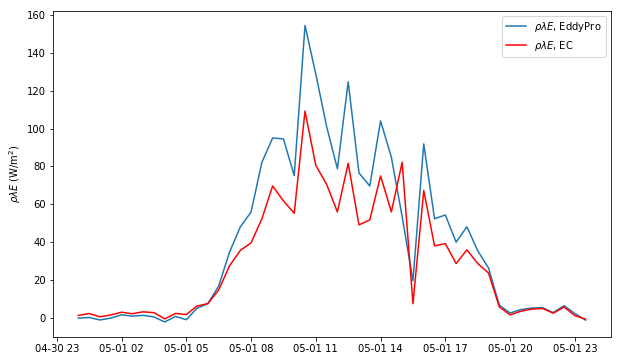

In [9]:
plt.figure(figsize=(10,6))
plt.plot(dtime_array, df_eddypro.LE, label=r'$\rho \lambda E$, EddyPro')
plt.plot(dtime_array, LE, 'r', label=r'$\rho \lambda E$, EC')
plt.legend(loc='best')
plt.ylabel(r'$\rho \lambda E$ (W/m$^2$)')

In [10]:
#Total energy for evaporation:
evap_energy_EP     = df_eddypro.LE.mean() * 3600*24 #-> J/m2/d

#Conversion to mm/d:
E_EP               = evap_energy_EP/Lambda/rho_w #m3/m2/d = m/d
E_EP               = E_EP*1000 #mm/d

print('Total daily evaporation after corrections: %.2f mm' % E_EP)

Total daily evaporation after corrections: 1.39 mm
